# Ramsey interferometry using Operational Quantum Tomography

Ramsey interterferometry is a process by which we can determine the Rabi oscillation frequency of a qubit. This is the intrinsic oscillation frequency of a qubit between its $|0\rangle$ and $|1\rangle$ states when it sits in an oscillating magnetic field. This is, for example, the situation in an ion trap quantum computing device. In such machines, operations on single qubits are performed by applying electromagnetic pulses of varying duration in order to get a desired superposition state - knowing the Rabi frequency helps us determine how long to make these pulses.

Ramsey interferometry is done by performing experiments of the form:
 1. Prepare state $|0\rangle$
 2. Perform a rotation of $\pi/2$ around the $x$-axis of the Bloch sphere, $R_x(\pi/2)$
 3. Wait for time $t$
 4. Perform another $R_x(\pi/2)$ pulse
 5. Measure in the computational basis
If we perform experiments for varying amounts of time $t$, we will see that the output probability of $|0\rangle$ (or $|1\rangle$) oscillates at a particular frequency, from which we can extract the Rabi frequency.

In reality, however, all of the above operations are noisy - the $R_x(\pi/2)$ pulses may be over-rotated, there may be SPAM error, and there will be decoherence due to interaction with the environment. In this notebook we will perform Ramsey interferometry in the OQT framework in order to learn the behaviour of all these processes in a self-consistent, and *gauge independent* manner.

Let's start by importing the required libraries and plotting tools.

In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi': 200}
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../src/")

from tqdm import tqdm

import numpy as np
np.set_printoptions(suppress = True, precision = 6)

import qinfer as qi

# OQT libraries
import oqt
from oqt.distributions import *
from oqt.errors import *

## Set up a model in OQT

To perform OQT, we must represent our quantum system as a box with buttons. Note, however, that an assumption in OQT is that buttons perform a 'discrete' operation that is the same every time that button is pressed. Thus, we will need to discretize the continuous wait time between $R_x(\frac{\pi}{2})$ pulses to finite amounts $dt$.

Our OQT button box will have four buttons:
- Prepare $|0\rangle$
- Apply $R_x(\frac{\pi}{2})$, label `pi_over_2`
- Wait some amount of time dt, labeled `dt` (this is a $R_z(\omega \cdot dt)$ operation)
- Measure in computational basis

We also need to choose an informationally complete set of fiducials to act as our reference frame. We choose:
- Do nothing
- $R_x(\frac{\pi}{2})$ 
- $R_x(\frac{\pi}{2}) R_x(\frac{\pi}{2})$
- $R_x(\frac{\pi}{2})$, waiting for time $dt$ $R_z(\omega \cdot dt)$, and then another $R_x(\frac{\pi}{2})$
Note that these are not tradiational Ramsey interferometry experiments!

With this, we will construct the gateset parameterization and the model.
- The parameterization, of type `GatesetParameterization` holds information about the gates in our gateset, the fiducials, and the model parameters that we will perform Bayesian inference over.

- The model, of type `GatesetModel` describes the distribution over the parameters, computes the likelihood function, and manages the experiments.



In [2]:
param = oqt.linear_parameterization.GatesetParameterization(
    # SPAM buttons are included implicitly in a GatesetParamerization
    gateset_labels= ['pi_over_2', 'dt'],             
    fiducial_labels = [[], 
                       ['pi_over_2'],  
                       ['pi_over_2', 'pi_over_2'], 
                       ['pi_over_2', 'dt', 'pi_over_2']
                      ]
)

model = qi.BinomialModel(oqt.linear_parameterization.GatesetModel(param))

## Simulating a Ramsey experiment

Instead of using real experimental data from a Ramsey experiment, we will simulate data by choosing a random oscillation frequency, and random noisy versions of the other operations. We will call this the *true* gate set. We will construct superoperators for these gates in the Pauli basis so that they are all in the same gauge, and manifestly operationally positive (and easy to write down!). 

In [3]:
# Uncomment to sample randomly
#true_dt = BlochRotationDistribution(axis='z', theta=qi.UniformDistribution(ranges=[0, 1])).sample()
#print(true_dt)

# This is the frequency used in the paper
w_true = 0.346754
dt = 1 # Some small amount of time to wait
wt = w_true * dt
true_dt = oqt.gates.super_rot_z(th=wt)
print(true_dt)

[[ 1.        0.        0.        0.      ]
 [ 0.        0.940481 -0.339847  0.      ]
 [ 0.        0.339847  0.940481  0.      ]
 [ 0.        0.        0.        1.      ]]


We choose the $R_x(\frac{\pi}{2})$ pulse from a distribution with overrotations, $\pi/2 \pm \varepsilon$ where $\varepsilon$ is randomly chosen with mean 0 and variance $10^{-3}$.

In [4]:
# Uncomment to sample randomly from the prior distribution
# ideal_pi_over_2 = BlochRotationDistribution(axis='x', theta=qi.NormalDistribution(np.pi/2, 0.001)).sample()

# The arbitrary value chosen for the paper
th = np.pi/2 - 0.003824

true_pi_over_2 = oqt.gates.super_rot_x(th=th) # value used in the paper
print(true_pi_over_2)

[[ 1.        0.        0.        0.      ]
 [ 0.        1.        0.        0.      ]
 [ 0.        0.        0.003824 -0.999993]
 [ 0.        0.        0.999993  0.003824]]


We'll assume that both $\rho$ and $E$ are slightly depolarized.

In [5]:
# The depolarization channel error here are set to constant value 
vec_ρ = np.array([1, 0, 0, 1]) / np.sqrt(2) # preparing |0><0|
ρ_prior = oqt.distributions.ConstantStateDistribution(
    state=vec_ρ, 
    channel_error=oqt.errors.DepolarizingChannel(p=qi.ConstantDistribution([0.038311])))
true_ρ = ρ_prior.sample().flatten()

vec_E = np.array([1, 0, 0, 1]) / np.sqrt(2) # measuring |0><0| 
E_prior = oqt.distributions.ConstantStateDistribution(
    state=vec_E, 
    channel_error=oqt.errors.DepolarizingChannel(p=qi.ConstantDistribution([0.023933])))
true_E = E_prior.sample().flatten()

true_spam = np.einsum("i,j->ij", true_ρ, true_E)
print(true_spam)

[[0.5      0.       0.       0.488033]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.480844 0.       0.       0.469336]]


Construct an object called a <i> gate set tensor</i>, or gs_tensor. This is the object used by the OQT software to hold the explicit, gauge-dependent versions of the superoperators. It's a record array labeled by the names of the buttons.

In [6]:
gs_tensor_true = np.empty((), param.gs_tensor_dtype)
gs_tensor_true['dt'] = true_dt
gs_tensor_true['pi_over_2'] = true_pi_over_2
gs_tensor_true[str(oqt.gates.WellKnownGates.SPAM)] = true_spam

# Print the contents
print(f"dt =\n {gs_tensor_true['dt']}\n")
print(f"pi_over_2 =\n {gs_tensor_true['pi_over_2']}\n")
print(f"SPAM =\n {gs_tensor_true['WellKnownGates.SPAM']}")

dt =
 [[ 1.        0.        0.        0.      ]
 [ 0.        0.940481 -0.339847  0.      ]
 [ 0.        0.339847  0.940481  0.      ]
 [ 0.        0.        0.        1.      ]]

pi_over_2 =
 [[ 1.        0.        0.        0.      ]
 [ 0.        1.        0.        0.      ]
 [ 0.        0.        0.003824 -0.999993]
 [ 0.        0.        0.999993  0.003824]]

SPAM =
 [[0.5      0.       0.       0.488033]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.480844 0.       0.       0.469336]]


## Constructing the operational representation

Now we will shift gears over to gauge-independent parameters, into something the <i>operational representation</i>. These are vectors and matrices that serve as our reference frame and are constructed using experimentally obtained measurement frequencies over the fiducials and one application of our gate set buttons.

This transformation is handled entirely within the `GatesetParameterization`. This is what  $\tilde{E}, \tilde{F}$, and $\tilde{G}_k$ look like in full.

In [7]:
pr_tensor_true = param.gs_tensor_to_pr_tensor(gs_tensor_true)
print(f"E~ = \n{pr_tensor_true['J']}\n") # E_tilde is formerly known as J
print(f"F~ = \n{pr_tensor_true['I']}\n") # F_tilde is formerly known as I
print(f"G~k = \n{pr_tensor_true['G']}")

E~ = 
[0.969336 0.501795 0.030677 0.058611]

F~ = 
[[0.969336 0.501795 0.030677 0.058611]
 [0.501795 0.030677 0.494616 0.49483 ]
 [0.030677 0.494616 0.969282 0.941349]
 [0.058611 0.49483  0.941349 0.969285]]

G~k = 
[[[0.501795 0.030677 0.494616 0.49483 ]
  [0.030677 0.494616 0.969282 0.941349]
  [0.494616 0.969282 0.508973 0.508546]
  [0.49483  0.941349 0.508546 0.562343]]

 [[0.969336 0.501795 0.030677 0.058611]
  [0.501795 0.058611 0.49483  0.549242]
  [0.030677 0.49483  0.969283 0.941765]
  [0.058611 0.549242 0.941765 0.966864]]]


We will use the contents of the $\tilde{E}, \tilde{F}$, and $\tilde{G}_k$ as our Bayesian model parameters. However, some of the quantities in these matrices represent the same probabilities, and so they must remain equal. As the Bayesian updater in general does not care how it perturbs each parameter, we need to extract a "non-redundant" set of model parameters. This is done by identifying which entries must be the same, and making mappings to and from the $\tilde{E}, \tilde{F}$, $\tilde{G}_k$ to the non-redundant vector.

Here, we see that rather than 52 parameters, we have 27 "unique" ones that can be safely individually perturbed.

In [8]:
true_params = param.gs_tensor_to_modelparams(np.array([gs_tensor_true]))
print(true_params)
print("Number of model parameters = " + str(param.n_modelparams))

[[0.969336 0.501795 0.030677 0.058611 0.494616 0.49483  0.969282 0.941349
  0.49483  0.941349 0.969285 0.508973 0.508546 0.508546 0.562343 0.969336
  0.501795 0.030677 0.058611 0.501795 0.549242 0.030677 0.969283 0.941765
  0.058611 0.941765 0.966864]]
Number of model parameters = 27


## Choosing a prior distribution

We have tried to make prior construction in OQT very flexible. There are a number of different choices, such as BlochRotations, ConstantDistributions, and random distributions such as the BCSZ superoperator distribution. Constructing a prior involves choosing distributions, distributions over their internal parameters, and adding any additional error channels.

In [9]:
unknown_operators = { 
      'pi_over_2' : BlochRotationDistribution(
          axis='x',         
          theta=qi.NormalDistribution(np.pi/2, 0.001)),

      'dt' : BlochRotationDistribution(
          axis='z', 
          theta=qi.UniformDistribution([0, 1])),

      'WellKnownGates.SPAM' : CombinedSPAMDistribution(
          state=ConstantStateDistribution(
              vec_ρ, 
              channel_error=DepolarizingChannel(p=qi.UniformDistribution(ranges=[0, 0.1]))),
          
          measurement=ConstantStateDistribution(
              vec_E, 
              channel_error=DepolarizingChannel(p=qi.UniformDistribution(ranges=[0, 0.1])))
       )
}

# The product distribution is constructed by specifying which operators are
# unknown (and thus must be sampled), and any that may be known.
prior = GSTProductDistribution(param, 
                               known_operators={}, 
                               unknown_operators=unknown_operators)

In [10]:
# Check out what the samples look like
prior.sample()

array([[0.99486 , 0.527649, 0.00823 , 0.009624, 0.417399, 0.417555,
        0.98254 , 0.981163, 0.417555, 0.981163, 0.982575, 0.636522,
        0.636212, 0.636212, 0.638687, 0.99486 , 0.527649, 0.00823 ,
        0.009624, 0.527649, 0.420494, 0.00823 , 0.982557, 0.981492,
        0.009624, 0.981492, 0.983205]])

## Learning the operational representation through Bayesian inference

Under the hood, OQT performs Sequential Monte Carlo using the QInfer libraries. We find 10000 particles works quite well for this example.

In [11]:
# Set up the particle and SMC updater
n_particles = 10000
updater = qi.SMCUpdater(model, n_particles, prior)

Let's now set up a sequence of experiments: we will do sequences like $R_x(\frac{\pi}{2})$, dt$^n$, $R_x(\frac{\pi}{2})$ for $n=2$ to $n=50$.
We will repeat each experiment 50 times. 

In [12]:
training_experiments = []   
min_time = 2
max_time = 50

for n in range(min_time, max_time):
    experiment = np.empty((1,), dtype=model.expparams_dtype)
    experiment[0]['sequence'] = oqt.gates.GSeq(
        [('pi_over_2', 1), ('dt', n), ('pi_over_2', 1)]
    )
    experiment[0]['n_meas'] = 50
    training_experiments.append(experiment)

In [13]:
training_experiments[5]['sequence']

array([GSeq(('pi_over_2', 1), ('dt', 7), ('pi_over_2', 1))], dtype=object)

Now we run the experiments one by one, and perform Bayesian updates.

In [14]:
for idx_experiment, experiment in tqdm(enumerate(training_experiments)):
    # Run an experiment
    datum = model.simulate_experiment(true_params, experiment)
    # Update the model parameters
    with qi.perf_testing.numpy_err_policy(invalid='raise'):
        updater.update(datum, experiment)

48it [00:06,  7.39it/s]


Things sampled from our reconstructed distribution should be very close to the true one after training!

In [15]:
updater.sample()

array([[0.977002, 0.520353, 0.026215, 0.054   , 0.439243, 0.441331,
        0.964179, 0.93668 , 0.441331, 0.93668 , 0.964744, 0.600262,
        0.596117, 0.596117, 0.646065, 0.977002, 0.520353, 0.026215,
        0.054   , 0.520353, 0.497312, 0.026215, 0.964465, 0.941035,
        0.054   , 0.941035, 0.969821]])

In [16]:
true_params

array([[0.969336, 0.501795, 0.030677, 0.058611, 0.494616, 0.49483 ,
        0.969282, 0.941349, 0.49483 , 0.941349, 0.969285, 0.508973,
        0.508546, 0.508546, 0.562343, 0.969336, 0.501795, 0.030677,
        0.058611, 0.501795, 0.549242, 0.030677, 0.969283, 0.941765,
        0.058611, 0.941765, 0.966864]])

In [14]:
# Save the posterior distribution details
# Save the data
prefix = "../data/ramsey/2020-03-25"
#np.save(f"{prefix}-posterior-locs.npy", updater.particle_locations)    
#np.save(f"{prefix}-posterior-wgts.npy", updater.particle_weights)

particle_locations = np.load(f"{prefix}-posterior-locs.npy")
particle_weights = np.load(f"{prefix}-posterior-wgts.npy")

## Prediction loss

Now that the updater seems to have converged to a distribution close to our true parameters, let's see how it fares with new gate sequences. In general, we want to learn what our gates do for <i>any</i> sequence of button presses, not just ones we've seen before.

To test this, we ask the following question: Is the likelihood of obtaining a detector click with our estimated distribution comparable to the true value?

In [15]:
# Generate some longer experiments
long_experiments = []   
old_min_time = min_time
min_time = max_time # Use the old value of max time, however many experiments we did above
max_time = min_time + 50

for n in range(min_time, max_time):
    experiment = np.empty((1,), dtype=model.expparams_dtype)
    experiment[0]['sequence'] = oqt.gates.GSeq([('pi_over_2', 1), ('dt', n), ('pi_over_2', 1)])
    experiment[0]['n_meas'] = 100
    long_experiments.append(experiment)

# Tack them on to the end of the current experiments list
validation_experiments = training_experiments + long_experiments

# Extend the dt_presses array to include both old and new experiments
dt_presses = np.array([
    experiment['sequence'][0].button_histogram()['dt']
    for experiment in validation_experiments
])

largest_training_dt = np.array([
    experiment['sequence'][0].button_histogram()['dt']
    for experiment in training_experiments
]).max()

Run the longer experiments.

In [16]:
pn = np.zeros(len(validation_experiments)) # The true probabilities, just the trace of the gate sequence
pn_hat = np.zeros(len(validation_experiments)) # The Bayesian mean probabilities, computed by averaging over the posterior distribution
outcomes = np.array([0], dtype='uint') # We want to calculate likelihood of outcome 0 for each particle in the cloud

for idx_experiment, experiment in enumerate(validation_experiments):    
    # Calculate the true probability using the experiment's button sequence
    pn[idx_experiment] = 1 - param.sequence_probability(gs_tensor_true, experiment['sequence'][0])

    # Calculate likelihood of 0 for each particle
    likelihoods = model.underlying_model.likelihood(outcomes, particle_locations, experiment)[0, :, 0]
    
    # "Integrate" over the posterior distribution given by the updater
    pn_hat[idx_experiment] = (likelihoods * particle_weights).sum()

Text(0.5, 1.0, 'Ramsey interferometry likelihood vs sequence length')

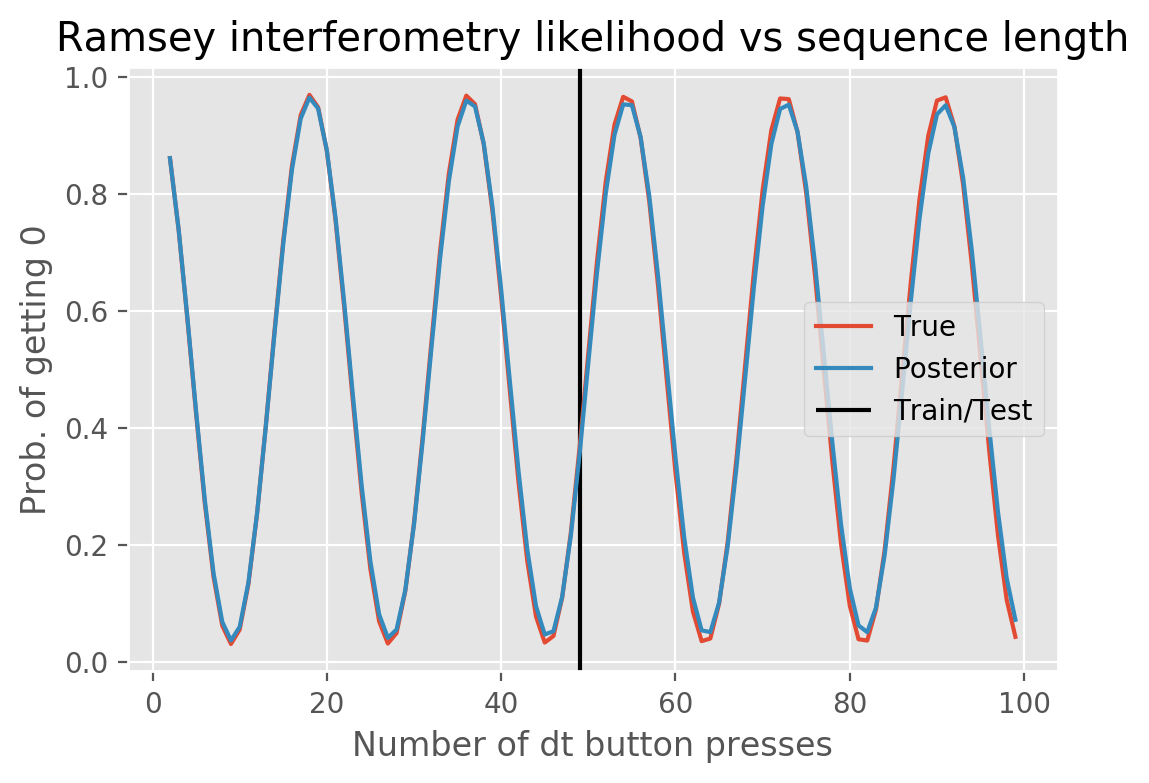

In [17]:
plt.plot(dt_presses, pn, label="True")
plt.plot(dt_presses, pn_hat, label="Posterior")
ylim = plt.ylim()
plt.vlines(largest_training_dt, *ylim, label='Train/Test')
plt.ylim(*ylim)
plt.xlabel('Number of dt button presses')
plt.ylabel('Prob. of getting 0')
plt.legend(loc='center right')
plt.title("Ramsey interferometry likelihood vs sequence length")
#plt.savefig("ramsey_likelihood.pdf")

Let's plot the prediction loss and KL divergence as well.

Text(0.5, 1.0, 'Ramsey interferometry prediction loss')

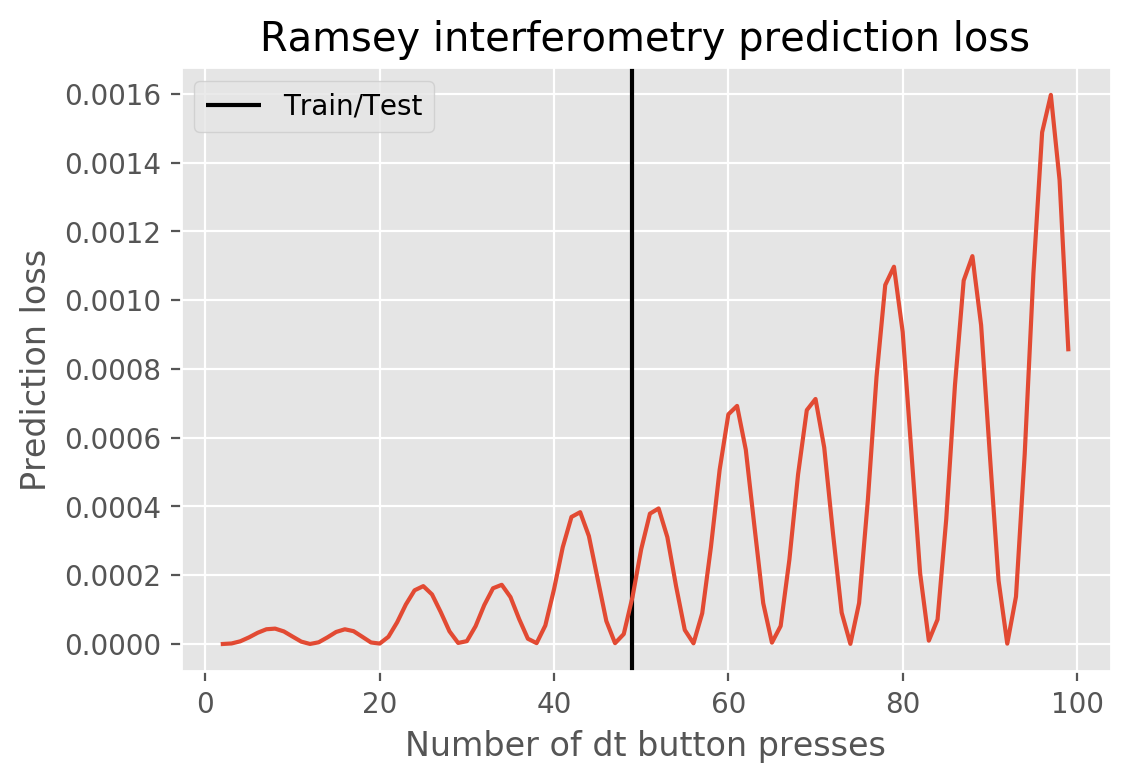

In [18]:
plt.plot(dt_presses, (pn - pn_hat)**2)
ylim = plt.ylim()
plt.vlines(largest_training_dt, *ylim, label='Train/Test')
plt.ylim(*ylim)
plt.xlabel('Number of dt button presses')
plt.ylabel('Prediction loss')
plt.legend()
plt.title("Ramsey interferometry prediction loss")
#plt.savefig("ramsey_predictionloss.pdf")

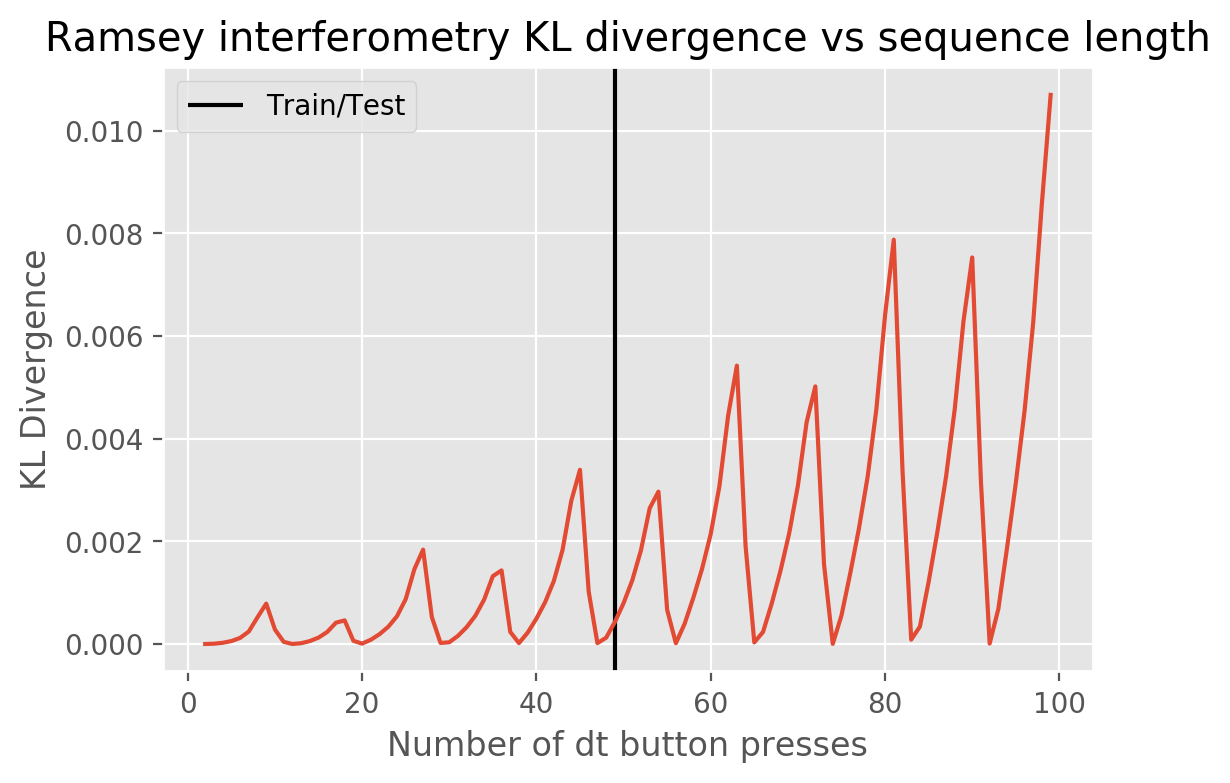

In [19]:
plt.plot(dt_presses, pn * np.log2(pn / pn_hat) + (1 - pn) * np.log2((1 - pn) / (1 - pn_hat)))
ylim = plt.ylim()
plt.vlines(largest_training_dt, *ylim, label='Train/Test')
plt.ylim(*ylim)
plt.xlabel('Number of dt button presses')
plt.ylabel('KL Divergence')
plt.title("Ramsey interferometry KL divergence vs sequence length")
plt.legend();
#plt.savefig("ramsey_kldiv.pdf")

The following produces a plot showing the distance of the particles from the true value as we go to longer and longer sequences.

In [20]:
# Each sequence length will represent one row of these matrices
true_probs = np.zeros(len(validation_experiments))
posterior_probs = np.zeros((len(validation_experiments), n_particles))
mean_posterior_probs = np.zeros(len(validation_experiments))
std_posterior_probs = np.zeros(len(validation_experiments))

for idx_experiment, experiment in enumerate(validation_experiments):
    # True sequence probability
    true_probs[idx_experiment] = 1 - param.sequence_probability(gs_tensor_true, experiment['sequence'][0])
    
    # Sequence probabilities for all particles in the posterior
    posterior_probs[idx_experiment,:] = model.underlying_model.likelihood(outcomes, particle_locations, experiment)[0, :, 0]
    
    # Mean probability weighted over posterior
    mean_posterior_probs[idx_experiment] = (posterior_probs[idx_experiment,:] * particle_weights).sum()

# Adjust the data to have a floating mean; look at the difference between the guessed probability and the true one
floating_posterior_probs = posterior_probs - true_probs[:, np.newaxis]

# Create the two arrays to plot and then flatten them to make 1D vectors
flat_seq_lengths = np.repeat(dt_presses, n_particles, axis = 0)
flat_posterior_probs = floating_posterior_probs.flatten()

mean_floating_posterior_probs = np.einsum("j...,ij->ij...", particle_weights, floating_posterior_probs).sum(axis = 1)

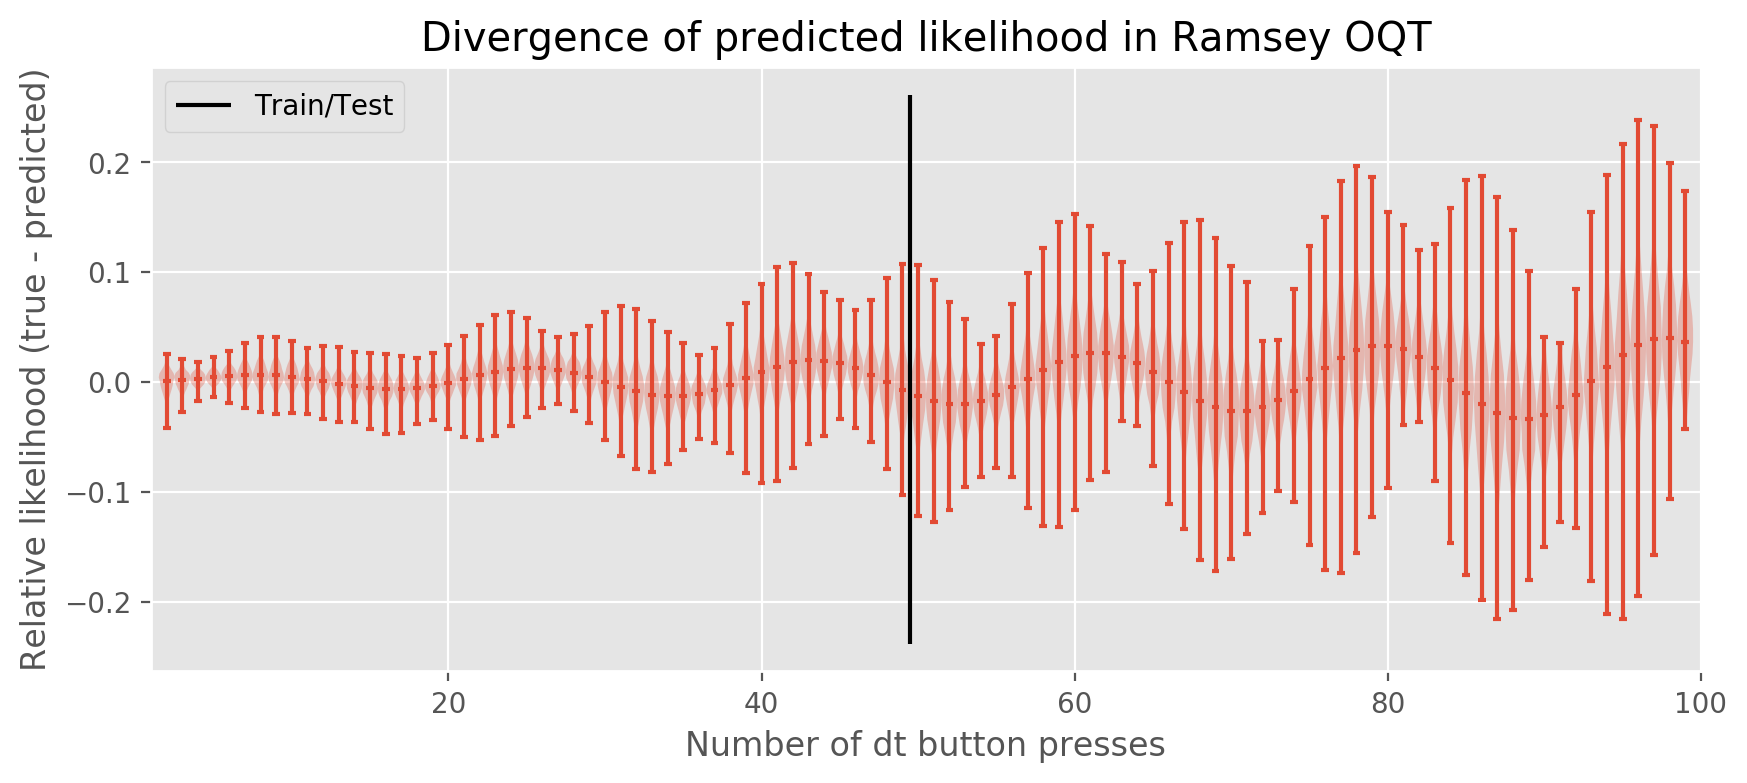

In [21]:
plt.figure(figsize=(10, 4))
plt.violinplot(list(floating_posterior_probs), dt_presses, points=20, widths=1,
                     showmeans=True, showextrema=True, showmedians=False);
plt.ylabel("Relative likelihood (true - predicted)")
plt.xlabel("Number of dt button presses")
plt.xlim(1, 100)
plt.title("Divergence of predicted likelihood in Ramsey OQT")
plt.vlines(largest_training_dt + 0.5, *plt.ylim(), label='Train/Test')
plt.legend(loc='upper left')
#plt.savefig("ramsey_floating_likelihood_violin.pdf")

From the previous plot, we can see that the relative likelihood begins to diverge; we can take things a step further and analyze what happens to the trajectories of individual particles as the sequence lengths increase substantially.

Text(0.5, 1.0, 'Posterior trajectories for trained Ramsey model')

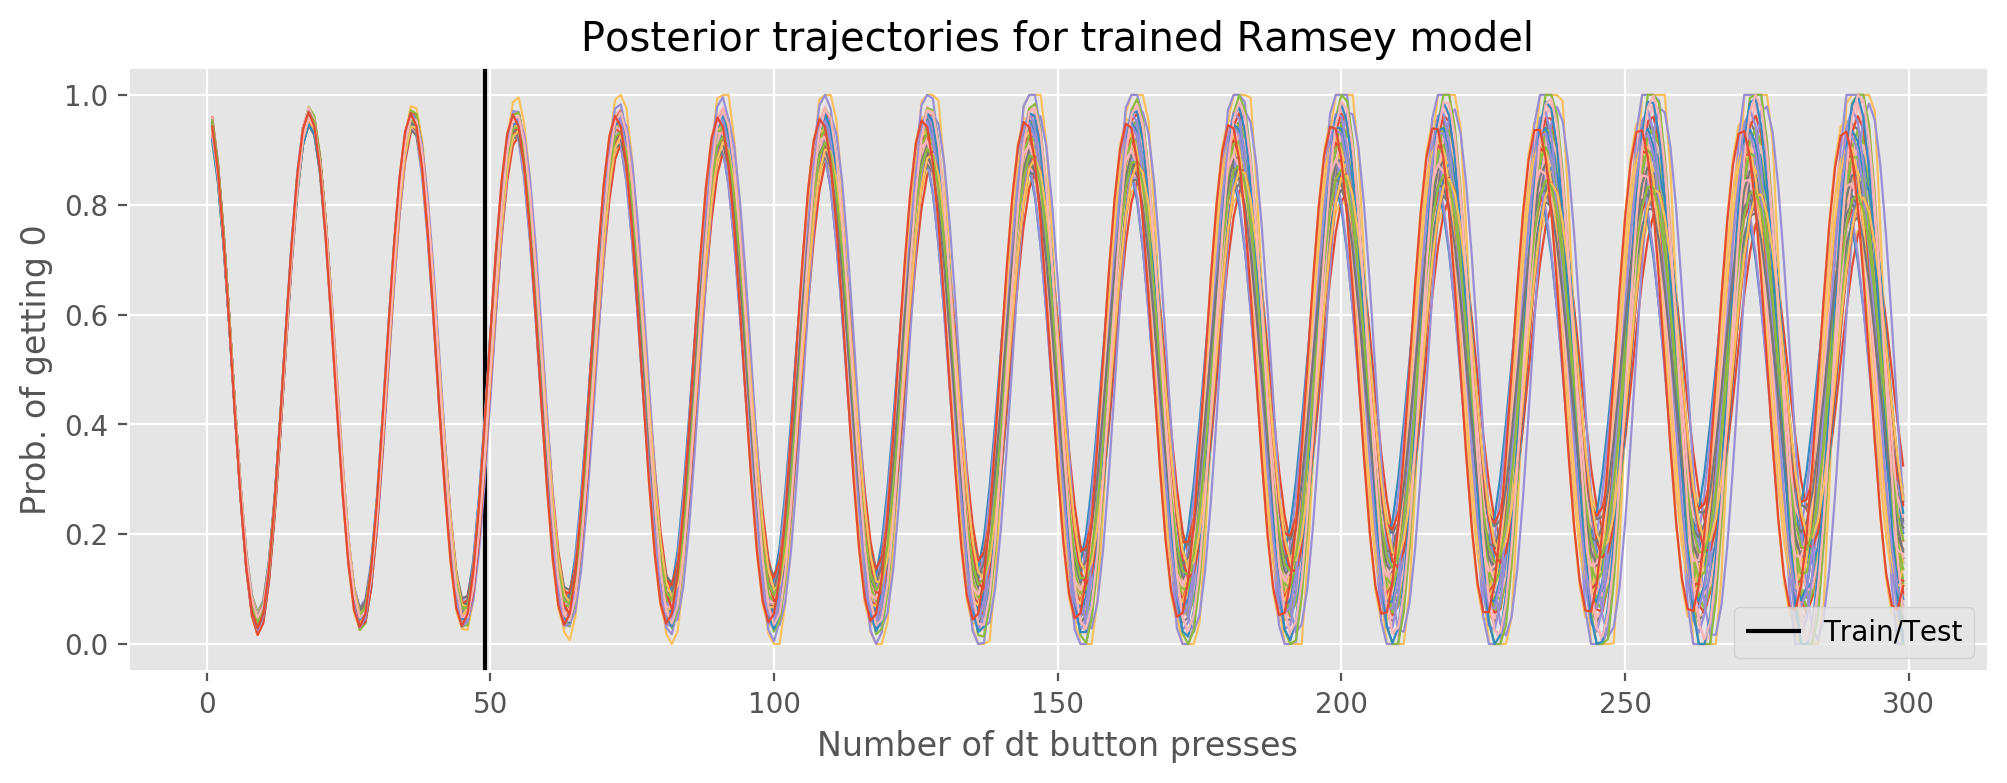

In [22]:
n_trajectories = 50
sample_ids = np.random.choice(n_particles, n_trajectories, replace=False)
traj_particles = particle_locations[sample_ids, :]

# Fix some bounds for the number of sequences we want to evaluate at; step by 5 because
# otherwise the plot gets really hairy
min_traj_length = 1
max_traj_length = 300
sequence_lengths = list(range(min_traj_length, max_traj_length))

trajectories = np.zeros((n_trajectories, len(sequence_lengths)))

for seq_idx in range(len(sequence_lengths)):
    experiment = np.empty((1,), dtype=model.expparams_dtype)
    experiment[0]['sequence'] = oqt.gates.GSeq([('pi_over_2', 1), ('dt', sequence_lengths[seq_idx]), ('pi_over_2', 1)])
    experiment[0]['n_meas'] = 100
    trajectories[:, seq_idx] = model.underlying_model.likelihood(outcomes, traj_particles, experiment)[0, :, 0]
    
# Make the plot
plt.figure(figsize=(12, 4))
plt.plot(np.array(sequence_lengths), trajectories.T, linewidth=0.8)
ylim = plt.ylim()
plt.vlines(largest_training_dt, *ylim, label='Train/Test')
plt.ylim(*ylim)
plt.xlabel('Number of dt button presses')
plt.ylabel('Prob. of getting 0')
plt.legend()
plt.title("Posterior trajectories for trained Ramsey model")
#plt.savefig("trajectories.pdf")

## Extracting the oscillation frequency

We can try and fit a curve in order to estimate the value of $\omega$. We can use curve fit, but we'll have to do some work by eye so that it chooses a frequency and amplitude that are in line with our output data. 

In [23]:
from scipy.optimize import curve_fit

def ramsey_freq(n, A, w):
    return A * (np.cos(w * n / 2) ** 2)

exp_qloss, stats = curve_fit(ramsey_freq, dt_presses, pn_hat, p0 = [1, 0.35])
print(exp_qloss)

[0.974262 0.345905]


We can see that the obtained frequency is only 0.6% higher than the true value of 0.346754. We can plot this curve and see that it matches well in terms of the obtained frequency, but we note that the curve amplitude is slightly smaller.  

Text(0.5, 1.0, 'Oscillation frequency of posterior vs. fit')

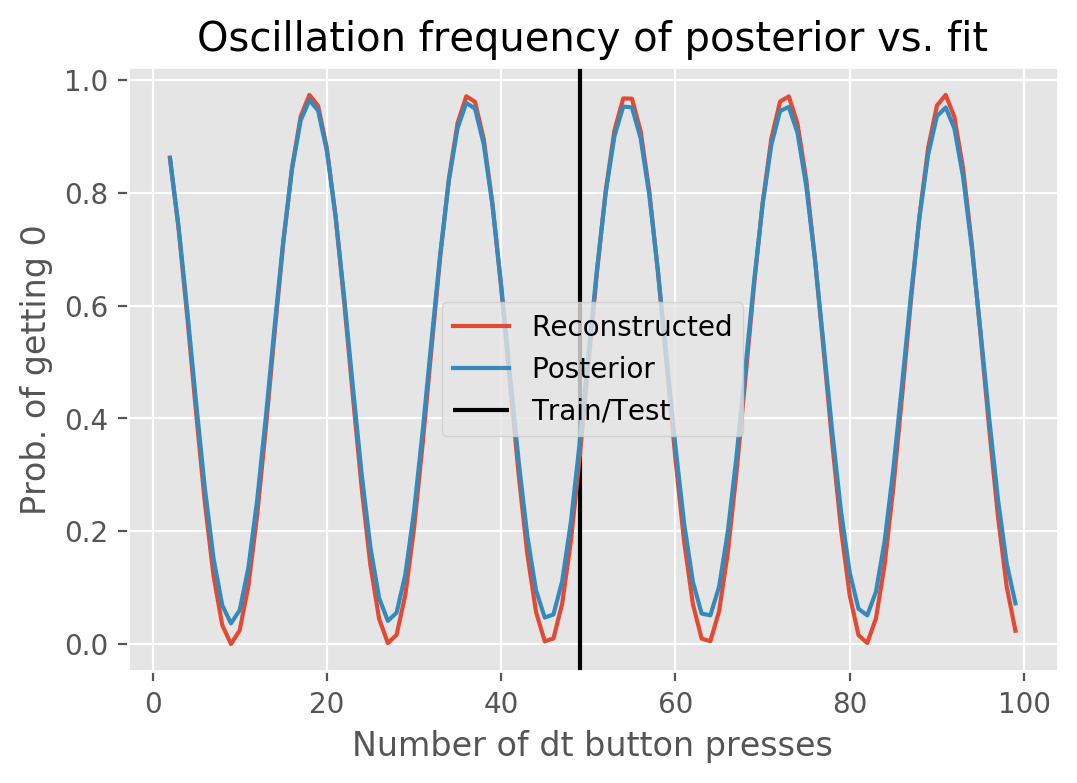

In [24]:
points = [ramsey_freq(x, *exp_qloss) for x in dt_presses]

plt.plot(dt_presses, points, label="Reconstructed")
plt.plot(dt_presses, pn_hat, label="Posterior")
ylim = plt.ylim()
plt.vlines(largest_training_dt, *ylim, label='Train/Test')
plt.ylim(*ylim)
plt.xlabel('Number of dt button presses')
plt.ylabel('Prob. of getting 0')
plt.legend()
plt.title("Oscillation frequency of posterior vs. fit")